In [6]:
import pandas as pd
from datetime import datetime
import bs4
import random
import requests
import json
# !pip install fake-useragent
from fake_useragent import UserAgent
import itertools as it

urls = {
    'OneDrive': 'https://androidapksfree.com/onedrive/com-microsoft-skydrive/old/',
    'MiHome'  : 'https://androidapksfree.com/mihome/com-xiaomi-smarthome/old/',
    'WhatsApp': 'https://androidapksfree.com/whatsapp-messenger/com-whatsapp/old/',
    'Facebook': 'https://androidapksfree.com/facebook/com-facebook-katana/old/',
    'YouTube' : 'https://androidapksfree.com/youtube/com-google-android-youtube/old/',
    'Twitch' : 'https://androidapksfree.com/twitch-livestream-multiplayer-games-esports/tv-twitch-android-app/old/',
    'Twitter' : 'https://androidapksfree.com/twitter/com-twitter-android/old/',
    'Facebook Lite' : 'https://androidapksfree.com/facebook-lite/com-facebook-lite/old/',
    'Twitter Lite' : 'https://androidapksfree.com/twitter-lite/com-twitter-android-lite/old/',
    'Messenger' : 'https://androidapksfree.com/facebook-messenger/com-facebook-orca/old/',
    'Snapchat' : 'https://androidapksfree.com/snapchat/com-snapchat-android/old/',
    'LinkedIn' : 'https://androidapksfree.com/linkedin-app/linkedin/old/',
    'LinkedIn Lite' : 'https://androidapksfree.com/linkedin-lite/linkedin-lite/old/',
    'Instagram' : 'https://androidapksfree.com/instagram/com-instagram-android/old/',
    'Instagram Lite' : 'https://androidapksfree.com/instagram-lite/instagram-lite/old'
    
    
}

# https://www.proxy-list.download/HTTPS
# in case black list (seems to not be the case so I'm not using it for now)
# proxies = pd.read_csv('proxy_list.txt', header = None)
# proxies = proxies.values.tolist()
# proxies = list(it.chain.from_iterable(proxies))
proxies = []

def get_data(url, proxies):
    
    df = pd.DataFrame()
    ua = UserAgent()
    # proxy_pool = it.cycle(proxies)
    df_f = pd.DataFrame()
    # proxy = next(proxy_pool)
    try:
        response = requests.get(url, headers={'User-Agent': ua.random},timeout=30)
        return response.text
    except e:
        print("Skipping. Connnection error :", e)
                
    return 'error'

data = {}
for app, url in urls.items():
    data[app] = get_data(url, proxies)

In [7]:
import re

regex_size_extract = r".*Size: ?(.*)"
applications = {}
for app, d in data.items():
    versions = []
    soup = bs4.BeautifulSoup(d, 'html.parser')
    em_box = soup.find_all("article")
    for article in em_box:
        for div in article.find_all("div", {'class': 'date-on-tax'}):
            article_description = div.find_all("div")
            div_size = article_description[0].string
            div_date = article_description[2].find("span").string
            matches = re.search(regex_size_extract, div_size, re.MULTILINE)
            versions.append((div_date, matches.group(1).strip()))
    applications[app] = list(reversed(versions))[:-1]

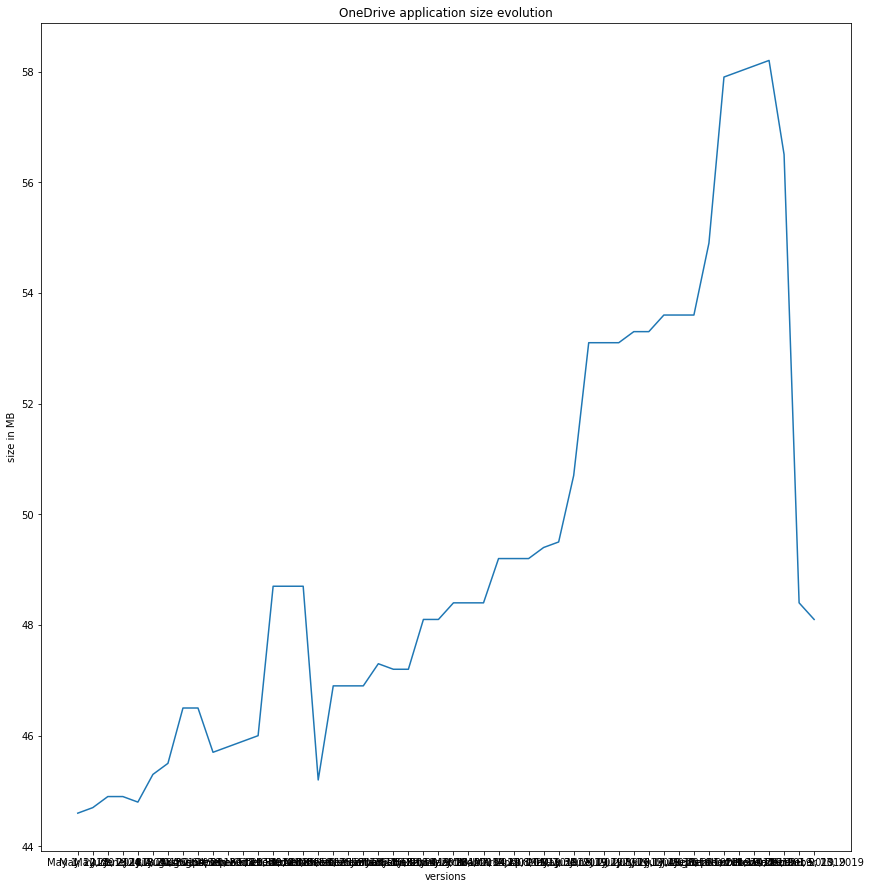

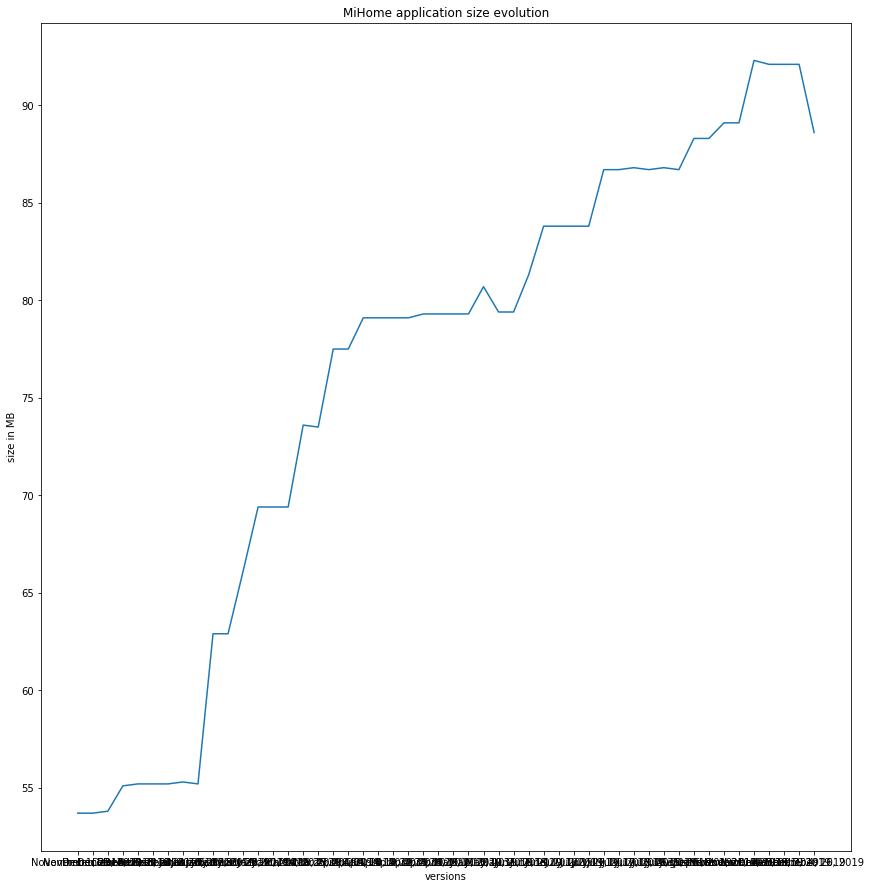

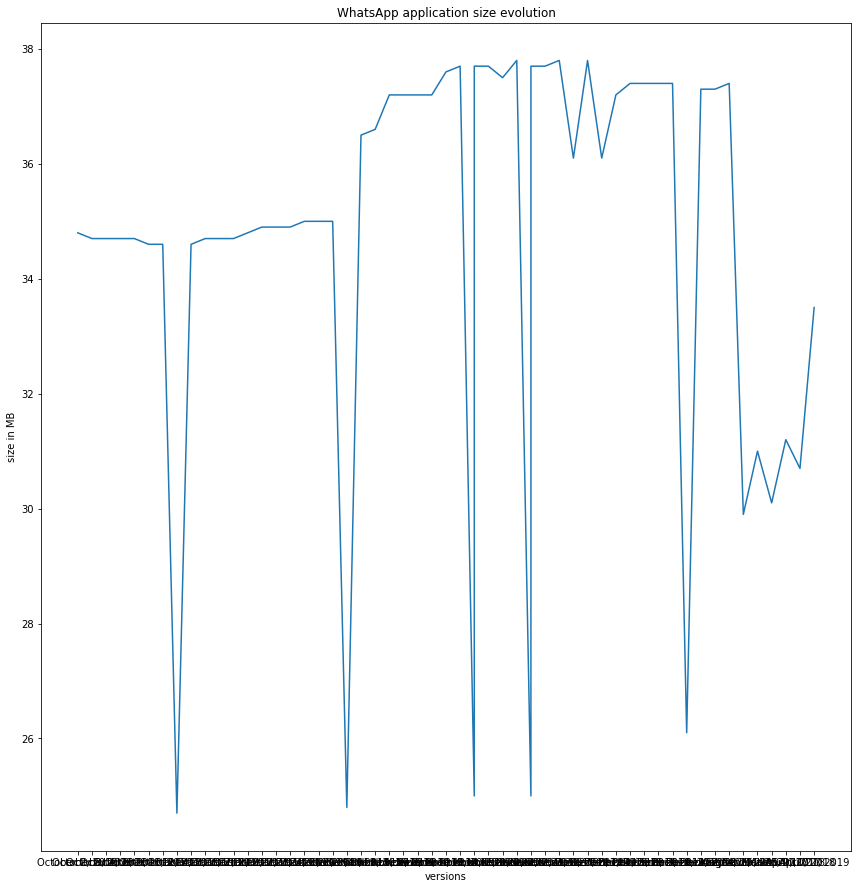

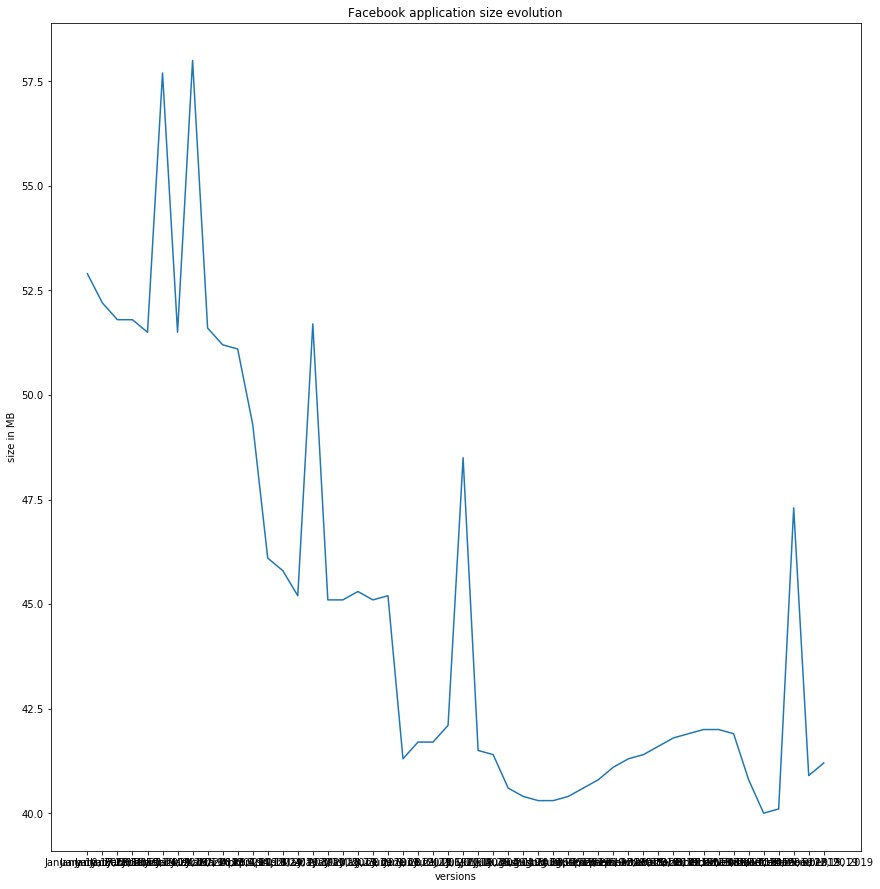

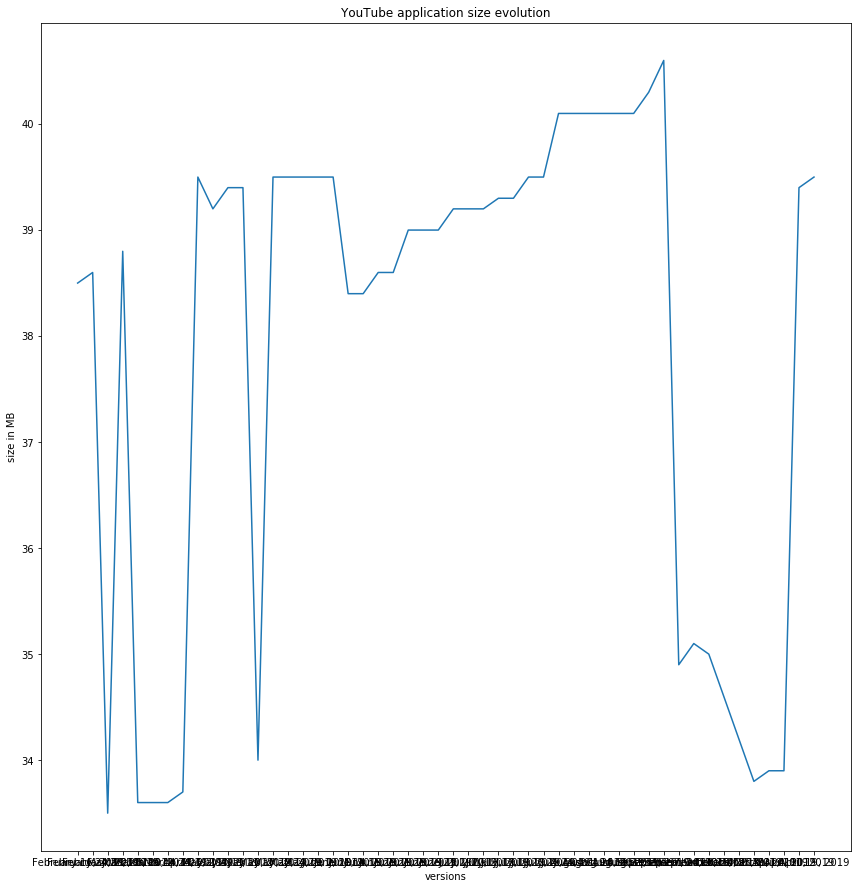

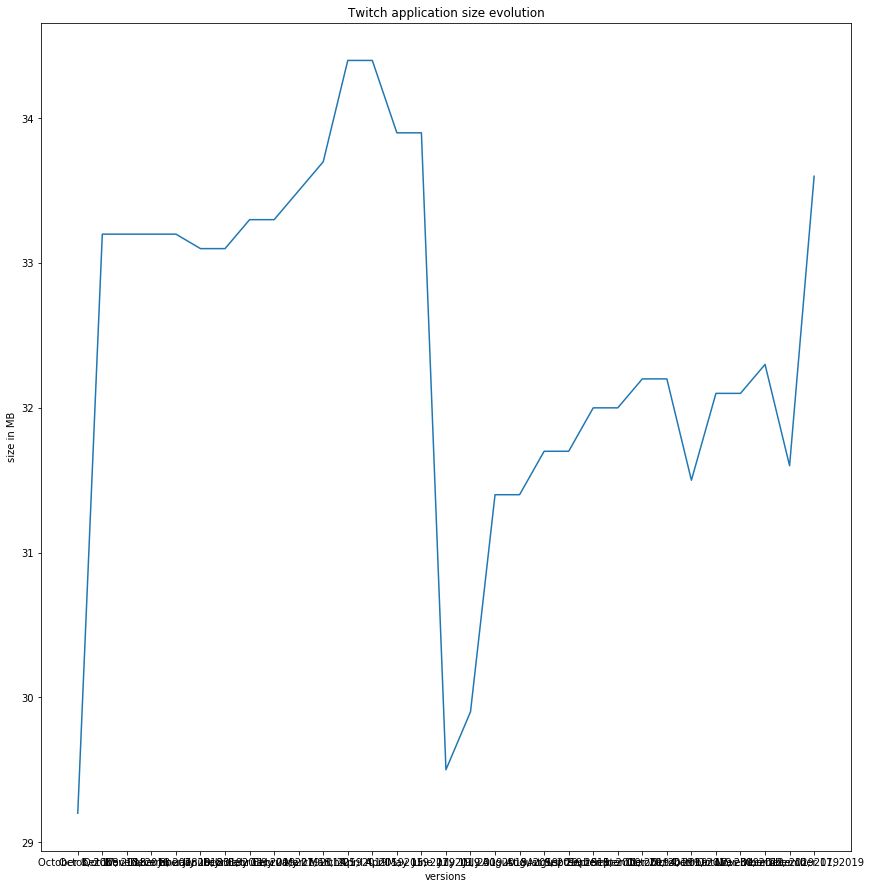

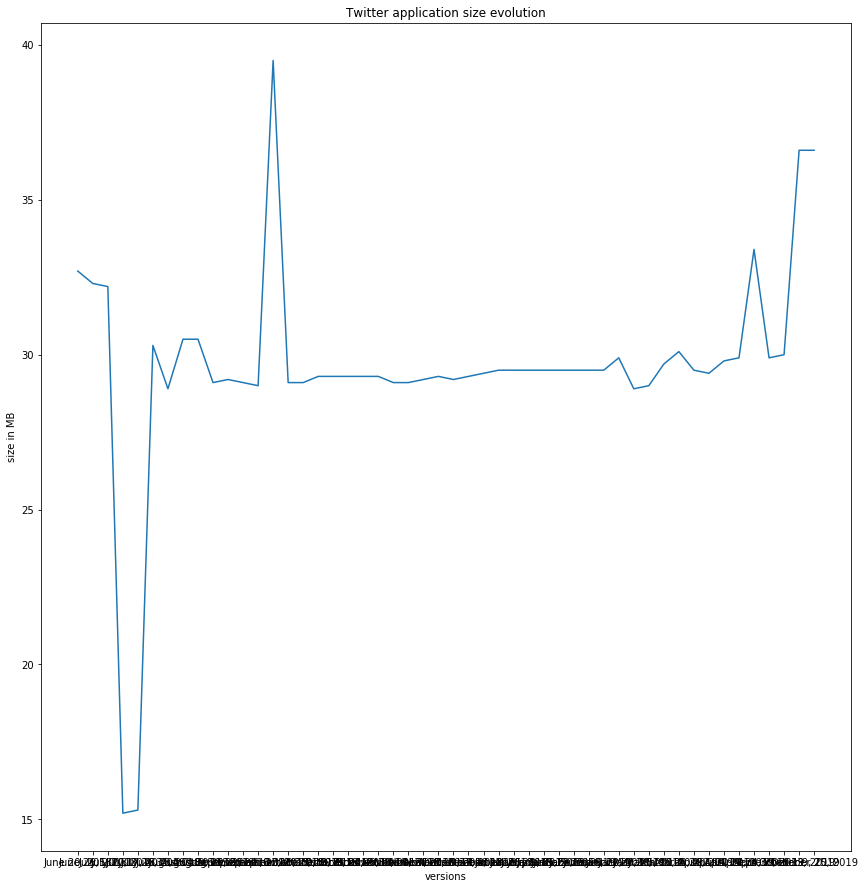

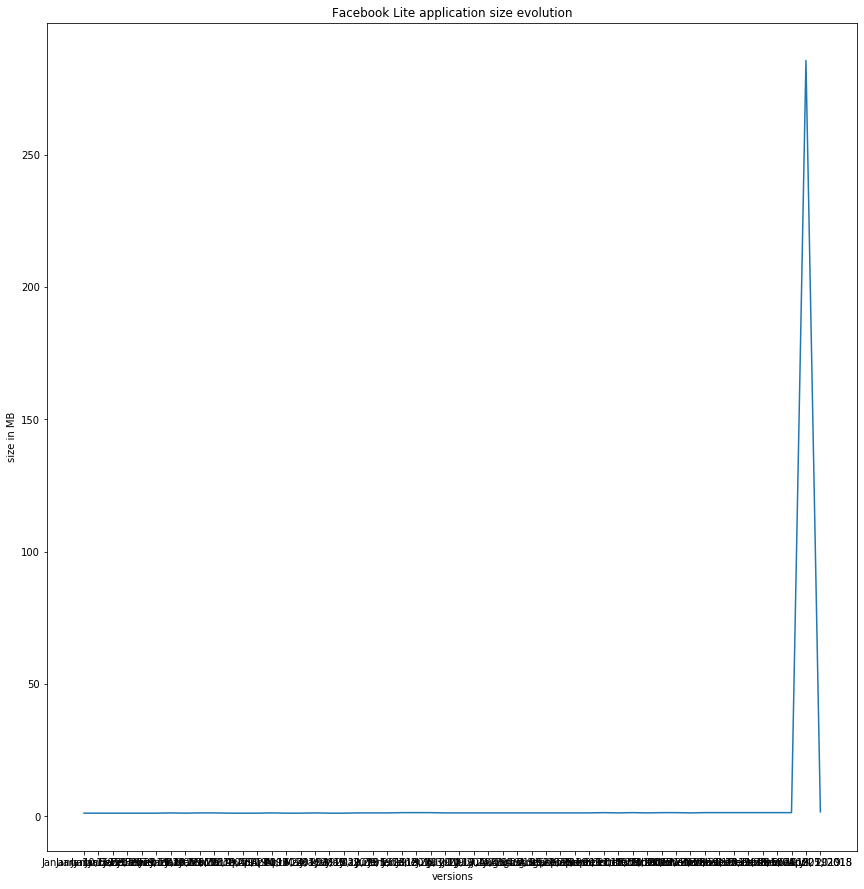

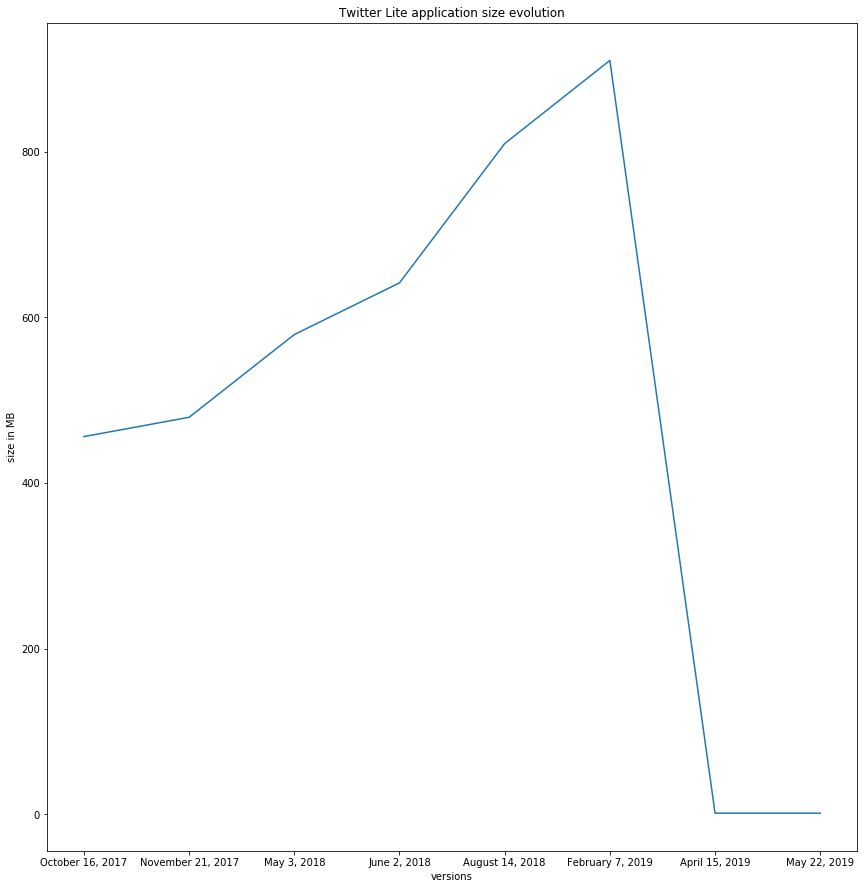

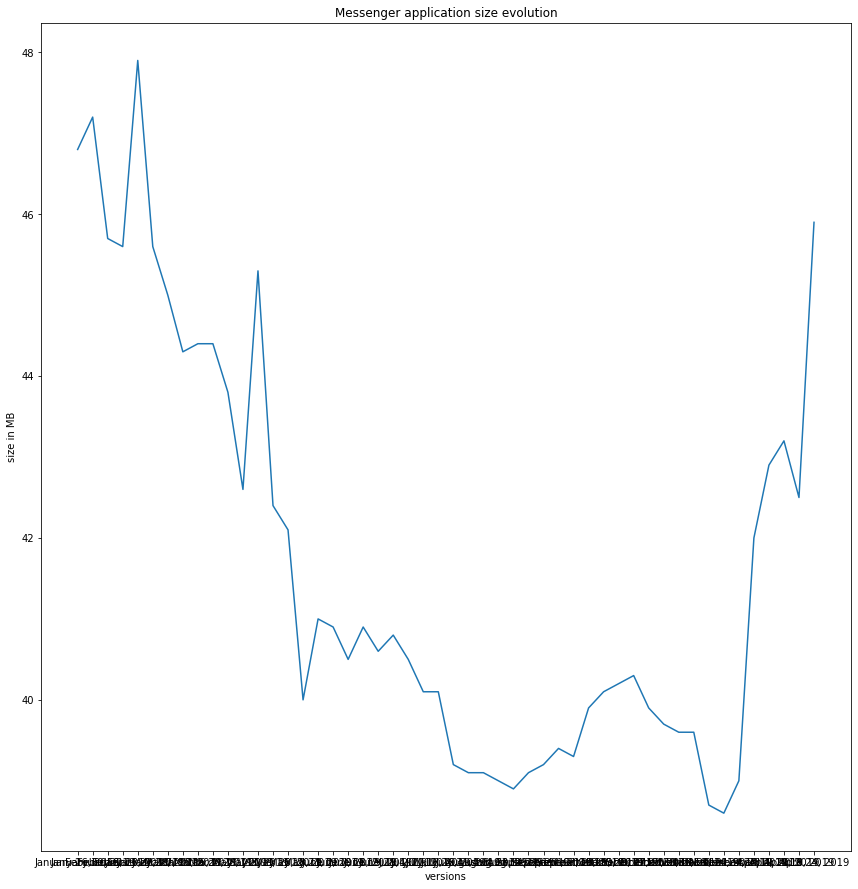

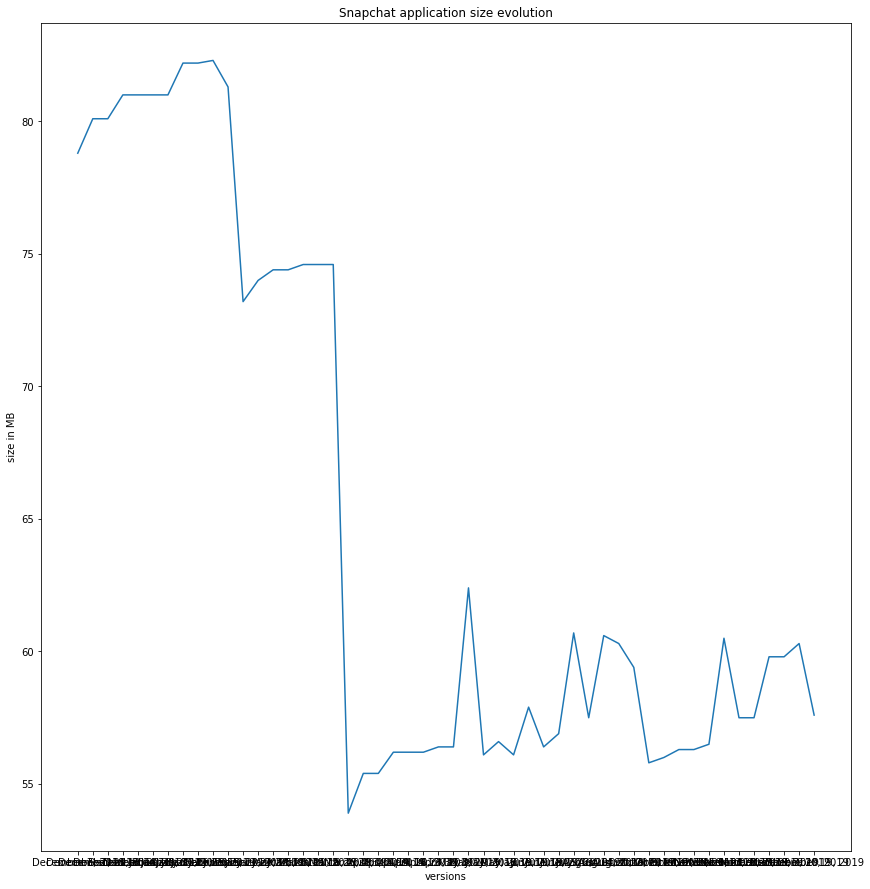

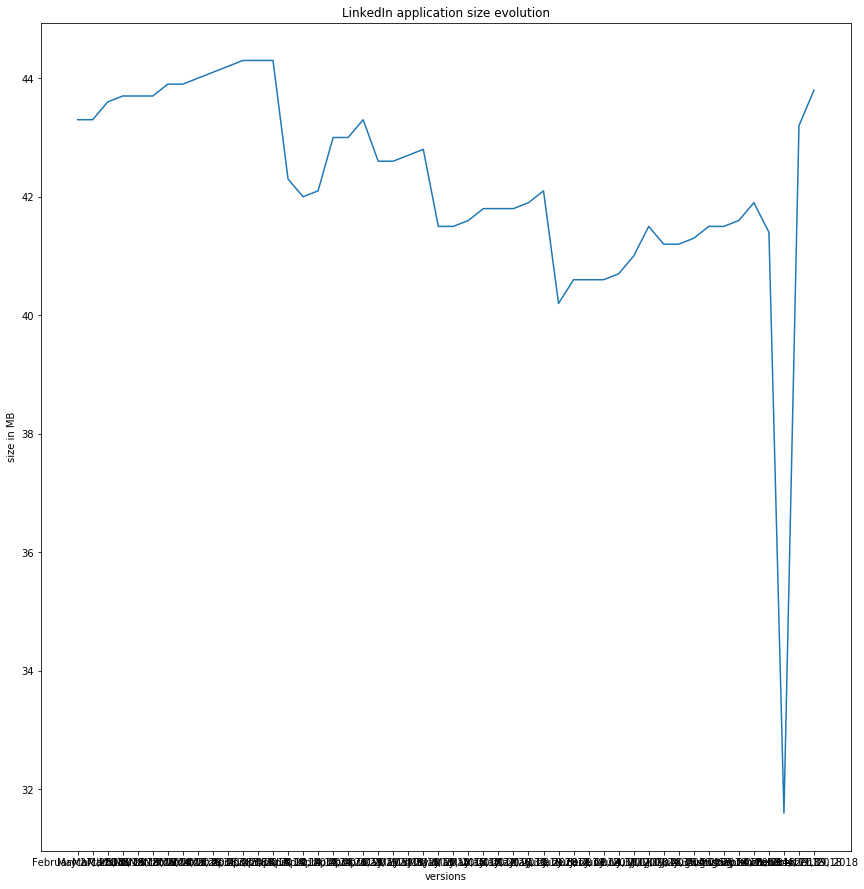

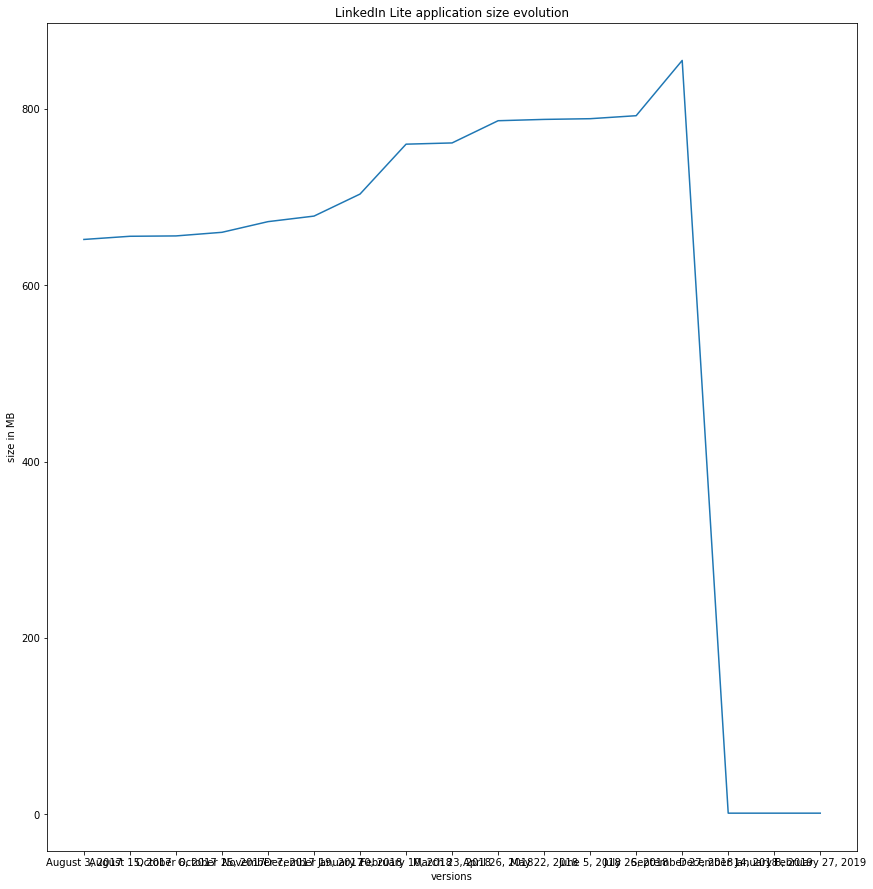

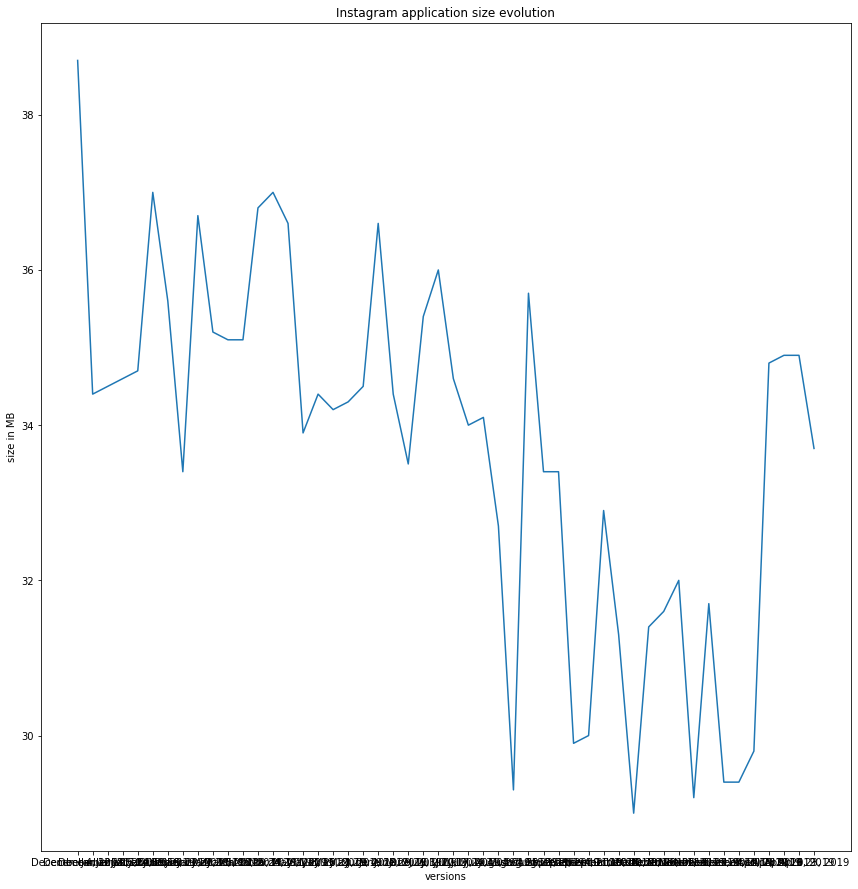

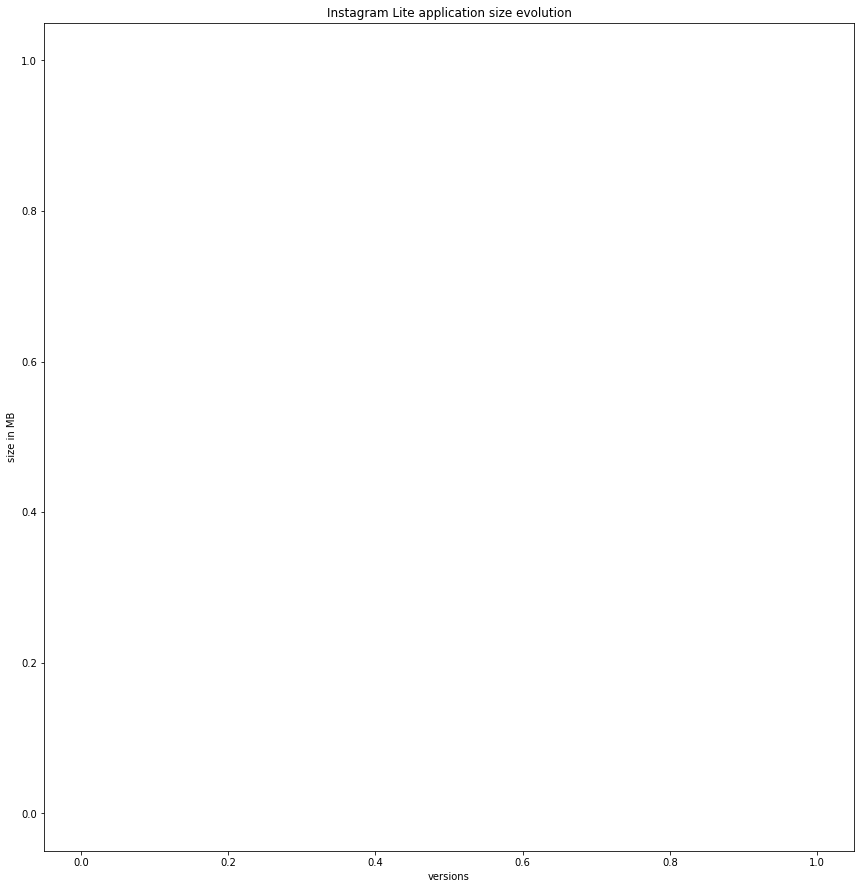

In [3]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

for name, app in applications.items():
    plt.plot([date for date, size in app], [float(size.split()[0]) for date, size in app])
    plt.xlabel('versions')
    plt.ylabel('size in MB')
    plt.title(name +' application size evolution')
    plt.subplots_adjust(top=3, right=2)
    plt.show()

In [13]:
def update_date(version):
    version_dict = dict()
    version_date = datetime.strptime(version[0], "%B %d, %Y")
    version_dict["date"] = version_date.strftime("%d-%m-%Y")
    l = version[1].split()
    if(l[1] == "MB"):
        l[0] = str(float(l[0]) * 1024)
        l[1] = "KB"
    version_dict["size"] = " ".join(l)
    return version_dict

def create_json(app) :
    versions = dict()
    versions["versions"] = list(map(update_date, app))
    return versions

In [14]:
applications_json = dict(map(lambda key_value: (key_value[0], create_json(key_value[1])), applications.items()))
file = open("data.json", "w")
file.write(json.dumps(applications_json, sort_keys=True, indent=4))
file.close()